# Analysis of Audience participant body sway, MusicLab Copenhagen


Generation of plots for Audience Motion paper

In [794]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [272]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
%reload_ext autoreload

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [5]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [6]:
internal_Part = general_loc + 'Participants_internal/'

In [7]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [8]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
sF = 10

In [9]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [11]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:5,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,Claps 0,0,Clapping
2021-10-26 17:36:53,-673.12,-673120,Speech MC1,Speech,964.12,117.08,Speech 1,1,Speech
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,Claps 1,2,Clapping
2021-10-26 17:38:56,-550.16,-550160,Speech MC2,Speech,1087.08,380.52,Speech 2,3,Speech
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,1.05,Claps 1.1,4,Clapping


In [12]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


One of the unfortunate characteristics of the cellphone measurements is their inconsistent sample rates and frequent gaps. Measurements per device were transmitted in 60 s batches, however there were (for as of yet undetermined reasons) often gaps between batches, sometimes of several seconds. These frequent discontinuities complicate how this data can be treated. Some steps taken were necessary compromises because of these measurement issues. There were also discontinuities from participants turning off the app to answer questions (remote participants only) or during intermission. To handle these gaps with care throughout these analyses, we inserted NaN values in any gaps lasting more than a second before resampling the ACC measurements to get Quantity of Motion measures on common timestamp values.

Lastly there was some data loss from phones lossing power or th app being accidentally or incidentally turned off/closed.

The individual participants accelerometer measurements during the concert experiment were resampled to matching timestamps at 50 Hz

In [13]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
#     print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1) 
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

140.11970901489258
140.2043809890747


In [14]:
aud_df.index = (ts_ct/1000).round(1) # index in seconds with one decimal
ori_aud_df = aud_df.copy()


In [15]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

# Power Spectrum analysis

In [16]:
def get_spectrogram(datain,F,W,J,scale='log'):
    '''Makes a spectrogram of the given data.
    #
    df: dataframe with data
    F: sampling frequency
    W: Window size
    J: Separation between windows
    #
    output: if input is Series output is a signle DF with spectrogram
            if intput is DF the output is dictionary with one spectrogram per column of the input dataframe
    '''
    K = range(0,len(datain)-W,J) # starting point for the windows
    K0 = [int(x+W/2) for x in K] # placing them in the middle point timestamp
    new_index = [datain.index[x] for x in K0] # extracting those timestamps
    col_freqs = [x*F/W for x in range(int(W/2)+1) ] # values of resolved freqs
    #   print(len(new_index),len(col_freqs))
    han = np.hanning(W)
    #dic = {'window_size':W,'sampling_frequency':F}
    #
    dic = {}
    for col in datain.columns:
        fourier = np.zeros((len(new_index),len(col_freqs)))
        temp = np.zeros((1,int(W/2)+1))
        j = 0
        D = datain[col]
#         D = D.diff() # discrete derivative
        D = D.dropna() # discarding nans and concatenating
        if len(D)==0:
            continue
        #   
        K0 = range(0,len(D)-W,J) # starting point for the windows
        for T0 in K0:
            data0 = D.iloc[T0:T0+W]*han
            if scale=='log':
                temp = 10*np.log10(2*abs(np.fft.fft(data0,axis=0)))
            elif scale=='abs':
                temp = abs(np.fft.fft(data0,axis=0))
            fourier[j,:] = temp[:int(W/2)+1]
            j = 1 + j
            #
        res = pd.DataFrame(fourier,index=new_index,columns=col_freqs)
#         res1 = res / (res.columns) # multiplicative adjustment for discrete derivative
        dic[col] = res#1      
        #print('Ready with ',col)
    output = dic
    #
    return output
#
def get_meanpowerspectrum(datain,F,W,J,scale='log'):
    # Obtained average spectrogram using the previous function
    spectrogram = get_spectrogram(datain,F,W,J,scale)
    dic = {}
    for key in spectrogram:
        dic[key] = spectrogram[key].mean(axis=0)
    output = pd.DataFrame(dic,index=dic[key].index)
    return output
#
#

In [328]:
sF = 10
FrameSize = 2**9
HopSize = 100

ETypes = ['Music','Survey','Speech','Applause']
minDur = 60 # s
MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')

Specs = {}
for i,r in MTs.iterrows():
    sigs=ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    Specs[r['Shorter_tag']] = get_meanpowerspectrum(sigs,sF,FrameSize,HopSize,scale='abs')
    

In [329]:
Specs.keys()

dict_keys(['Speech 1', 'Speech 2', 'Speech 3', 'Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Survey 1', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Claps 5', 'Survey 2', 'Speech 7', 'Bach', 'Survey 3', 'Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6', 'Claps 14', 'Survey 4'])

Combine power spectra per participant per meta event category. Note this needs to handle partial missing data from some participants

In [330]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df_means = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev_tag),:]
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df_means.loc[ev_tag,:] = fullset.mean()
df_means

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
Beethoven,0.069311,NaN,0.094418,0.101837,0.07339,0.108468,0.079436,0.086562,0.078947,0.132908,...,0.050851,0.209203,0.106644,0.164509,0.342741,0.182293,NaN,0.084129,0.272131,NaN
Schnittke,NaN,NaN,0.09243,0.143013,0.08211,0.1171,0.071236,0.08482,0.083305,0.106298,...,NaN,0.324734,0.160088,0.174884,0.288465,0.168656,NaN,NaN,0.142764,NaN
Bach,0.056344,0.135229,0.095909,0.124146,0.076237,0.103214,0.072805,0.075133,0.063821,0.103792,...,NaN,NaN,0.161927,NaN,NaN,NaN,0.041645,0.080859,0.044488,0.064046
Folk,0.090395,0.110848,0.12164,0.16044,0.102084,0.103741,0.122425,0.108638,0.077485,0.166454,...,0.13115,NaN,0.31208,1.033047,NaN,NaN,NaN,0.099888,0.068717,0.11593
Survey,0.209239,0.276741,0.138638,0.390651,0.154346,0.20982,0.193861,0.116464,0.160078,0.598902,...,2.63744,0.300593,NaN,0.21808,0.455517,NaN,NaN,0.257953,0.263718,0.225292
Speech,0.246232,0.292039,0.295855,0.372476,0.145761,0.229551,0.146598,0.182625,0.139083,0.437855,...,0.26774,0.461094,0.136921,0.538927,0.798314,0.263668,0.026651,0.132056,0.271759,0.362781
Clapping,0.938128,0.802796,1.06222,1.152516,0.567129,1.359547,1.303809,1.125798,0.856135,1.224338,...,0.235498,0.411525,0.168537,0.229127,0.441142,0.372743,0.443953,0.208247,0.400149,0.301939


In [331]:
ev = 'Speech'
sub_evs = Main_concert_times.query('Event.str.startswith(@ev)and Event_Duration > @minDur')
sub_evs['Shorter_tag']

Datetime
2021-10-26 17:36:53    Speech 1
2021-10-26 17:38:56    Speech 2
2021-10-26 17:47:02    Speech 3
2021-10-26 19:11:46    Speech 7
Name: Shorter_tag, dtype: object

In [332]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
SuperSpecs = {}
for ev in ev_tags:
    sub_evs = Main_concert_times.query('Event.str.startswith(@ev)and Event_Duration > @minDur')
    Parts = list(df_means.columns[df_means.loc[ev].notna()])
    df_parts = pd.DataFrame(columns = Parts)
    for partID in Parts:
        df=pd.DataFrame()
        for s in sub_evs['Shorter_tag']:
            if partID in Specs[s].columns:
                df[s] = Specs[s].loc[:,partID].copy()
        df_parts[partID] = df.mean(axis=1)
    SuperSpecs[ev]=df_parts.copy()

In [334]:
D_evs = []
for ev in SuperSpecs.keys(): # just in hall
    df = SuperSpecs[ev].loc[:,SuperSpecs[ev].columns.str.startswith('A')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
D = pd.concat(D_evs,axis=0)
D.replace([np.inf, -np.inf], np.nan, inplace=True)
D = D.dropna()

D_evs = []
for ev in Specs.keys(): # just in hall
    df = Specs[ev].loc[:,Specs[ev].columns.str.startswith('A')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
Ds = pd.concat(D_evs,axis=0)
Ds.replace([np.inf, -np.inf], np.nan, inplace=True)
Ds = Ds.dropna()

In [335]:
D_evs = []
for ev in SuperSpecs.keys(): # just Remote
    df = SuperSpecs[ev].loc[:,SuperSpecs[ev].columns.str.startswith('B')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
G = pd.concat(D_evs,axis=0)
G.replace([np.inf, -np.inf], np.nan, inplace=True)
G = G.dropna()

D_evs = []
for ev in Specs.keys(): # just Remote
    df = Specs[ev].loc[:,Specs[ev].columns.str.startswith('B')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
Gs = pd.concat(D_evs,axis=0)
Gs.replace([np.inf, -np.inf], np.nan, inplace=True)
Gs = Gs.dropna()

We also want to have the estimated distribution of resting heart rates for this population, given the ages represented. Note the true ages are used, according to survey responses from in hall participants, but the distribution is oversampled * 4 to stablise the quantile ranges used in the plots. The heart rate distributions are generated randomly from heart rate distributions reported by age with a single split linear model on age from mean and standard deviations. Parameters from https://www.nature.com/articles/s41746-019-0134-9

In [336]:
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1')
ages = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('A'),'age']

In [337]:
import random
random.seed(time.time())

def modelHR(age):
# https://www.nature.com/articles/s41746-019-0134-9#Sec2
# In healthy individuals, average resting HR-PPG decreased from 81.6 ± 14.0 in those aged 18–20 to 74.2 ± 12.7 in those aged 71–80 (p < 0.0005) (Table 2 and Fig. 1a).
# https://www.nature.com/articles/s41746-019-0134-9/figures/1
# split elbow model of average heart rates, bend at 55 for slop and spread
#     sigma = 14 - (14-12.7)*(age-19)/(80 - 19)
#     mu = 81.6 - (81.6-74.2)*(age-19)/(80 - 19)
    if age<55:
        sigma = 14
        mu = 81.6 - (81.6-73)*(age-19)/(55 - 19)
    else:
        sigma = 14 - (14-12.7)*(age-55)/(80 - 55)
        mu = 73 - (73-74.2)*(age-55)/(80 - 55)
    return random.gauss(mu,sigma)

Average modeled heart rates 75.61  (14.18), [.1,.25,.5,.75,.9] [58.83,66.61,75.78,84.57,90.89]


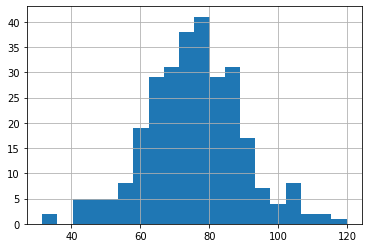

In [338]:
hrs = []
for a in ages: # over sample to smooth out the random 
    hrs.append(modelHR(a))
    hrs.append(modelHR(a))
    hrs.append(modelHR(a))
    hrs.append(modelHR(a))
hrs = pd.Series(hrs)
hrs.hist(bins=20)
quants = [hrs.quantile(0.1),hrs.quantile(0.25),hrs.quantile(0.5),hrs.quantile(0.75),hrs.quantile(0.9)]
print('Average modeled heart rates {:.2f}  ({:.2f}), [.1,.25,.5,.75,.9] [{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}]'.format(hrs.mean(),hrs.std(),quants[0],quants[1],quants[2],quants[3],quants[4]))

The exact values shift around with each random iteration. The values used in the published graph are representative of the trend across samplings, even if not exactly what gets rendered every time.

In [398]:
ev = 'Clapping'
a = D.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
print(60*a.loc[2:].idxmax())
1/a.loc[2:].idxmax()

Power    176.953125
dtype: float64


Power    0.339073
dtype: float64

In [416]:
a.loc[2.95:3.4]

,Power
Frequency,
2.968750,9.351017
2.988281,8.170758
3.007812,8.513904
3.027344,8.686249
3.046875,7.519140
3.066406,6.398480
3.085938,6.159883
3.105469,5.982286
3.125000,5.528586


In [442]:
60/0.34

176.47058823529412

In the applause, 2.8 Hzcorresponds to the clapping IBI (0.36 s) at the start of the synchronised clapping for the final interval. 2.97 is around 0.33 s, is the median of clapping 14. 

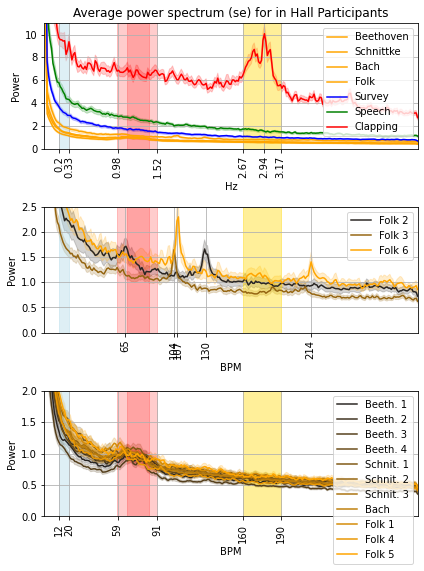

In [443]:
# General aspect of figure
fig, axes = plt.subplots(3,1,figsize=(6, 8))# ,sharex=True
errorbarType ='se' # 'ci' #
#
ax=axes[0]
Event_palette={'Beethoven':'orange','Schnittke':'orange','Bach':'orange','Folk':'orange',
        'Clapping':'red','Speech':'green','Survey':'blue','Synch':'purple'}
sns.lineplot(data=D, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band', palette=Event_palette,ax=ax)
# sns.lineplot(data=D, x='Frequency',y='Power',hue='Event',errorbar='se',err_style='band', palette=Event_palette,ax=ax)
ax.set(xlim=(0,5), ylim=(0, 11))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(quants[1]/60, quants[3]/60 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(quants[0]/60, quants[4]/60 ,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
Hzs = np.array([12,20,np.round(quants[0],0),np.round(quants[4],0),160,176.5,190])/60#74,
ax.set_xticks(Hzs)
ax.set_xticklabels(np.round(Hzs,2),rotation=90)
ax.set_xlabel('Hz')
ax.legend(loc='upper right')
ax.set_title('Average power spectrum (' + errorbarType + ') for in Hall Participants')
ax.grid()

ax=axes[2]
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach','Folk 1','Folk 4', 'Folk 5', ]
Ds_sub = Ds.query('Event in @sub_evs')
sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band', palette="dark:orange",ax=ax)
ax.legend(loc='upper right')
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(quants[1]/60, quants[3]/60 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(quants[0]/60, quants[4]/60 ,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
BPMs = np.array([12,20,int(np.round(quants[0],0)),int(np.round(quants[4],0)),160,190])#74,
ax.set_xticks(BPMs/60)
ax.set_xticklabels(BPMs,rotation=90)
ax.set_xlabel('BPM')
ax.set(xlim=(0,5),ylim=(0, 2))
ax.grid()

ax=axes[1]
sub_evs = ['Folk 2', 'Folk 3', 'Folk 6']
Ds_sub = Ds.query('Event in @sub_evs')
sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',hue_order = sub_evs,palette="dark:orange", errorbar=errorbarType,err_style='band',ax=ax) #
ax.set(xlim=(0,5),ylim=(0, 2.5))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(quants[1]/60, quants[3]/60 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(quants[0]/60, quants[4]/60 ,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
BPMs = np.array([65,104,107,130,214])#74,
ax.set_xticks(BPMs/60)
ax.set_xticklabels(BPMs,rotation=90)
ax.set_xlabel('BPM')
ax.legend(loc='upper right')
ax.grid()
plt.tight_layout()
plt.savefig('./plots/spectrum_Hall.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

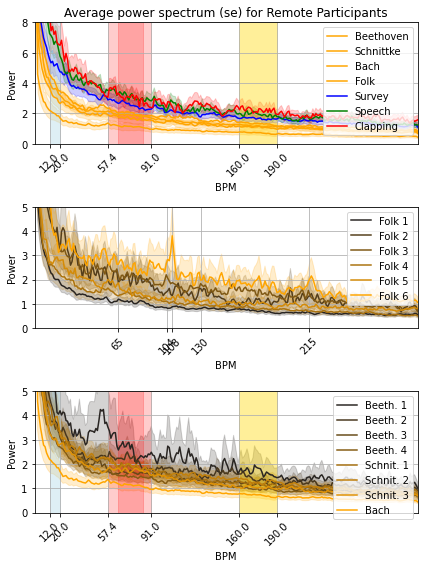

In [79]:
# 2. PLOTTING 
#
# General aspect of figure
fig, axes = plt.subplots(3,1,figsize=(6, 8)) # ,sharex=True

#
ax=axes[0]
Event_palette={'Beethoven':'orange','Schnittke':'orange','Bach':'orange','Folk':'orange',
        'Clapping':'red','Speech':'green','Survey':'blue','Synch':'purple'}
# errorbar=('se',2), errorbar='ci'
ax = sns.lineplot(data=G, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band', palette=Event_palette,ax=ax)
ax.set(xlim=(0,5), ylim=(0, 8))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(quants[1]/60, quants[3]/60 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(quants[0]/60, quants[4]/60 ,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
BPMs = np.array([12,20,np.round(quants[0],1),np.round(quants[4],1),160,190])#74,
ax.set_xticks(BPMs/60)
ax.set_xticklabels(BPMs,rotation=45)
ax.set_xlabel('BPM')
ax.legend(loc='upper right')
ax.set_title('Average power spectrum ('+errorbarType+') for Remote Participants')
ax.grid()

ax=axes[2]
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach',]
Ds_sub = Gs.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band',  palette="dark:orange",ax=ax)
ax.legend(loc='upper right')
ax.set(xlim=(0,5), ylim=(0, 5))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.axvspan(quants[1]/60, quants[3]/60 ,color='red',alpha=0.2) # estimated quantile range 
ax.axvspan(quants[0]/60, quants[4]/60 ,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4)
BPMs = np.array([12,20,np.round(quants[0],1),np.round(quants[4],1),160,190])#74,
ax.legend(loc='upper right')
ax.set_xlabel('BPM')
ax.set_xticks(BPMs/60)
ax.set_xticklabels(BPMs,rotation=45)
ax.grid()

ax=axes[1]
sub_evs = ['Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6']
# sub_evs = ['Folk 2', 'Folk 3', 'Folk 6']

Ds_sub = Gs.query('Event in @sub_evs')
sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event', palette="dark:orange",errorbar=errorbarType,err_style='band',ax=ax)
ax.set(xlim=(0,5), ylim=(0, 5))
BPMs = np.array([65,104,108,130,215])#74,
ax.set_xticks(BPMs/60)
ax.set_xticklabels(BPMs,rotation=45)
ax.set_xlabel('BPM')
ax.legend(loc='upper right')
ax.grid()
plt.tight_layout()
plt.savefig('./plots/spectrum_Remote.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

# Pairwise Correlation analysis and plots

Pairwise correlations were performed on 10Hz absolute Jerk values (1st order difference of ACC resampled at 10 Hz) to assess simultaneous motion. 

First pairwise correlations between all participants were performed to assess the contribution of the shared stimulus (the music performance and conditions) across the group in when they moved more or less. 

By sitting on the chest, these sensors have a chance of catching something of head and limb movements as well has changes of position in the torso, however interpretation of the scale of these motions from the measurements is impossible when their source cannot be distinguished. For example, applause can be distinguished because the resultant sensor motion is very distinct and proportional to the intensity of clapping, at least between rounds from individual participants. In contrast, the motion resultant from answering multiple choice questions on the paper surveys was much more variable in timing, shape, and scale, including factors from their posture (leaning forward to read and write on lap or sitting straight and writing against raised paper in hand) and writing gestures (dash, checkmark, or filled square). Besides ambiguity in the types of movements behind the measurements captured, the amount of time moving was relatively low throughout the concert. Most of these measurements stayed close to the noise floor as the audience sat attentively still, with only the occasional jump of values. In otherwords, the motion signal in these measurements is very sparse, and our priority is in capturing whether any signal was occuring at the same time, not whether the movements were of a similar scale through all the ambiguities of this hanging chest acc sensor.

We opted to use the spearman correlation to capture shared motion on these time series because of the indeterminent and sparse quality of the motion signals. By using rank instead of actual measure values, the metric reduce potential scaling differences in the rare and uneven (and unevenly captured) bursts of motion, while the high frequence noise-level variation at 10 hz reduce accidental inflations. In this sense, the spearman correlation values are a measure of how much simultaneous motion occurred between two people while a piece was performed (ie when moments with high rank coincided), with sensical low values for most peices. Note that we aren't using Spearman correlations with a test of significance per pair based on the samples or duration of these time series. Spearman's rho is only a metric of how often a pair of audience members simultaneously moved, not matter the kind of motion. 

These pairwise correlations are used to test two different influences on the motion of this audience: 1) the shared stimulus/activity across the whole in-hall audience, 2) the influence of audience members on each other, given where they were seated and whether they knew each other. In both cases, we are intersted to see if the music and non-musical concert experiment events showed relatively more or less effect on coincidental motion. 

The first use of the pairwise correlations was to evaluate whether the patterns of motion reflected the shared stimulus of the performance and concert hall for in hall participants. For any given segment of the concert (2 minutes length or longer), were in hall participants significantly more simultaneous in their movements than should happen by chance? Representing the coincidental motion performed was the complete comparison set between every participant with motion measured for that segment, for each audience member the average of their 10 Hz QoM time series correlated with every other audience members motion as sampled at that same time. To distinguish activity effects, null alternative correlation averages sets were generated with each participants's time series from one segment compared to all other in hall audience members for each other instance of the same activity: clapping with other instances of applause, music with other music, speeches with other speeches etc. For all these altenatives pairwise correlations, the longer segment signals had to be truncated to match in duration. 

A last note on interpreting coincidental motion as measured here: these signals were aligned to within 200 ms, or two samples at 10 Hz. While this too temporally blurry to capture the precision of alignment in motion between musicians, the measurable motions performed by the audience generally last more than 100 ms, giving a chance for overlap even if signal alignment is less than perfect. Again, for an evaluation of coincidental motion without focus on specific actions, this alignment quality is sufficient for capturing simultenaity between audience members.

Original analysis only performed on participants in the concert hall, as their alignment is of sufficient quality to compare at this resolution (10 Hz) and these same calculations are used to consider mutual influence between participants seated in proximity to each other.

In [91]:
hall_df = ori_aud_df.loc[:,ori_aud_df.columns.str.startswith('A')].copy()

In [92]:
partIDs = list(hall_df.columns)

Evaluate all average correlations per participant (to remaining in hall audience) and segment.

In [93]:
minDur = 45 

In [32]:
res = []
CORRS = {}
ETypes = ['Music','Survey','Speech','Applause']
method = 'spearman'

MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')
for i,r in MTs.iterrows():
    sigs=hall_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    corr1=sigs.corr(method='spearman')
    corr1.reset_index(drop=False,inplace=True)#.rename(columns={'index':'ID'})
    K = pd.melt(corr1, id_vars=['index'], value_vars=partIDs,var_name='Pair', value_name='Spearman')
    K['Event_Type']= r['Event_Type']
    K['Event']=r['Event']
    K['Event1']=r['Shorter_tag']

    res.append(K)
    CORRS[r['Shorter_tag']] = corr1

R = pd.concat(res, axis=0)
R = R.reset_index(drop=True)
Q = R.loc[R['Spearman'].notna(),:].query('index!=Pair') # remove nans and identities
Q.loc[:5,:]   

,index,Pair,Spearman,Event_Type,Event,Event1
1,ADQ002,ADQ001,-0.050404,Speech,Speech MC1,Speech 1
2,ADQ003,ADQ001,-0.100363,Speech,Speech MC1,Speech 1
3,ADQ004,ADQ001,-0.000815,Speech,Speech MC1,Speech 1
4,ADQ005,ADQ001,-0.068802,Speech,Speech MC1,Speech 1
5,ADQ006,ADQ001,0.090462,Speech,Speech MC1,Speech 1


In [82]:
G = pd.DataFrame(columns = ['Participant_Code','Event_Type','Event','Event1','Correlations'])
evs = Q['Event1'].unique()
k=0
for ev in evs:
    F = Q.query('Event1==@ev')
    parts = F['index'].unique()
    for partID in parts:
        E = F.query('index==@partID')
        row = E.iloc[0,:]
        G.loc[k,'Participant_Code'] = partID
        G.loc[k,'Event_Type'] = row['Event_Type']
        G.loc[k,'Event1'] = row['Event1']
        G.loc[k,'Event'] = row['Event']
        G.loc[k,'Correlations'] = E['Spearman'].mean()
        k+=1

evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
for ev in evord:
    G.loc[G['Event1'].str.startswith(ev[:4]),'Sections1'] = ev
G.loc[:5,:]

,Participant_Code,Event_Type,Event,Event1,Correlations,Sections1
0,ADQ002,Speech,Speech MC1,Speech 1,0.04394,Speech
1,ADQ003,Speech,Speech MC1,Speech 1,0.004353,Speech
2,ADQ004,Speech,Speech MC1,Speech 1,0.03049,Speech
3,ADQ005,Speech,Speech MC1,Speech 1,0.046602,Speech
4,ADQ006,Speech,Speech MC1,Speech 1,0.020656,Speech
5,ADQ007,Speech,Speech MC1,Speech 1,-0.004698,Speech


In [34]:
G.to_csv('QoM_pairwise.csv')

Generate the set of alternatives for each segment, by comparing to others in the same category of events.

In [83]:
res = []
ETypes = ['Music','Survey','Speech','Applause'] #
method = 'spearman'

MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')
for i,r in MTs.iterrows():
    sigs1=hall_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    for j,q in MTs.iterrows():
        if r['Event_Type'] == q['Event_Type']:
            if r['Shorter_tag'] != q['Shorter_tag']:
                sigs2=hall_df.loc[q['Time_s']:q['Time_s']+q['Event_Duration'],:].copy()
                L = np.min([len(sigs1),len(sigs2)])-1
                corr1 = pd.concat([sigs1.iloc[:L,:].reset_index(drop=True),sigs2.iloc[:L,:].reset_index(drop=True)],axis=1).corr(method='spearman')
                corr2 = corr1.iloc[len(partIDs):,:len(partIDs)].copy()
                corr2.reset_index(drop=False,inplace=True)#.rename(columns={'index':'ID'})
                K = pd.melt(corr2, id_vars=['index'], value_vars=partIDs,var_name='Pair', value_name='Spearman')
                K['Event_Type']= r['Event_Type']
                K['Event1']=r['Shorter_tag']
                K['Event2']=q['Shorter_tag']
                res.append(K)

R = pd.concat(res, axis=0)
R = R.reset_index(drop=True)
Qalt = R.loc[R['Spearman'].notna(),:].query('index!=Pair')
Qalt.loc[:5,:] 

,index,Pair,Spearman,Event_Type,Event1,Event2
2,ADQ003,ADQ001,0.056985,Speech,Speech 1,Speech 2
3,ADQ004,ADQ001,-0.031947,Speech,Speech 1,Speech 2
4,ADQ005,ADQ001,0.028335,Speech,Speech 1,Speech 2
5,ADQ006,ADQ001,0.014574,Speech,Speech 1,Speech 2


In [84]:
Galt = pd.DataFrame(columns = ['Participant_Code','Event_Type','Event1','Event2','Correlations'])
evs = Qalt['Event1'].unique()
k=0
for ev1 in evs:
    D = Qalt.query('Event1==@ev1 or Event2==@ev1')
    for ev2 in evs:
        F = D.query('Event1==@ev2 or Event2==@ev2')
        parts = F['index'].unique()
        for partID in parts:
            E = F.query('index==@partID')
            row = E.iloc[0,:]
            Galt.loc[k,'Participant_Code'] = partID
            Galt.loc[k,'Event_Type'] = row['Event_Type']
            Galt.loc[k,'Event1'] = row['Event1']
            Galt.loc[k,'Event2'] = row['Event2']
            Galt.loc[k,'Correlations'] = E['Spearman'].mean()
            k+=1
Galt.iloc[:5,:]

,Participant_Code,Event_Type,Event1,Event2,Correlations
0,ADQ003,Speech,Speech 1,Speech 2,0.014848
1,ADQ004,Speech,Speech 1,Speech 2,0.016573
2,ADQ005,Speech,Speech 1,Speech 2,0.021118
3,ADQ006,Speech,Speech 1,Speech 2,0.004145
4,ADQ007,Speech,Speech 1,Speech 2,0.010661


In [85]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']
Galt['Sections1'] = ''
Galt['Sections2'] = ''
for ev in evord:
    Galt.loc[Galt['Event1'].str.startswith(ev[:4]),'Sections1'] = ev
    Galt.loc[Galt['Event2'].str.startswith(ev[:4]),'Sections2'] = ev
Galt.iloc[:5,:]

,Participant_Code,Event_Type,Event1,Event2,Correlations,Sections1,Sections2
0,ADQ003,Speech,Speech 1,Speech 2,0.014848,Speech,Speech
1,ADQ004,Speech,Speech 1,Speech 2,0.016573,Speech,Speech
2,ADQ005,Speech,Speech 1,Speech 2,0.021118,Speech,Speech
3,ADQ006,Speech,Speech 1,Speech 2,0.004145,Speech,Speech
4,ADQ007,Speech,Speech 1,Speech 2,0.010661,Speech,Speech


In [39]:
Galt.to_csv('altQoM_pairwise.csv')

From the original pairings, tag the pairings that will be used for the spatial and relationships analysis to follow and save the results

In [448]:
Sub_Rels = pd.read_csv('./data/Audience/Sub_Relationships_Hall_Rand_Distant.csv', index_col=0)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
909,ADQ003,ADQ008,4.0,0,Stranger
910,ADQ003,ADQ048,4.0,0,Stranger
911,ADQ055,ADQ059,4.0,0,Stranger
912,ADQ043,ADQ060,4.0,0,Stranger


In [449]:
ev = 'Music'
A=Q.copy()

for ev in evord:
    A.loc[A['Event1'].str.startswith(ev[:4]),'Sections'] = ev
A.loc[:,'Relationship'] = ''
A.loc[:,'Familiarity'] = 0
A.loc[:,'Distance'] = np.nan
A.loc[:,'Close'] = 0


for i,rel in Sub_Rels.iterrows():
    p1 = rel["Participant_Code_1"]
    p2 = rel["Participant_Code_2"]
    V = A.query('index==@p1 and Pair==@p2')
    A.loc[V.index,'Relationship']=rel['Relationship']
    A.loc[V.index,'Familiarity']=rel['Familiarity']
    A.loc[V.index,'Distance']=rel['Distance']
    if rel['Distance']<4.0:
        A.loc[V.index,'Close']=1
C = A.query('Close==1').copy()
C.to_csv('pairwiseRelsRandDist.csv')

In [451]:
C = A.query('Distance>-3').copy()
C.to_csv('pairwiseRelsRandDist.csv')

Now plot and mark the t-test comparisons between the correlations between participants, true and null/alternative, evaluating which intervals of the concert showed shared patterns of motion. 

In [94]:
G = pd.read_csv('QoM_pairwise.csv',index_col=0)
Galt= pd.read_csv('altQoM_pairwise.csv',index_col=0)

In [95]:
# why pandas do you suddenly fail to recognise consistent data types within columns?
G['Correlations'] = G['Correlations'].astype('float')
Galt['Correlations'] = Galt['Correlations'].astype('float')


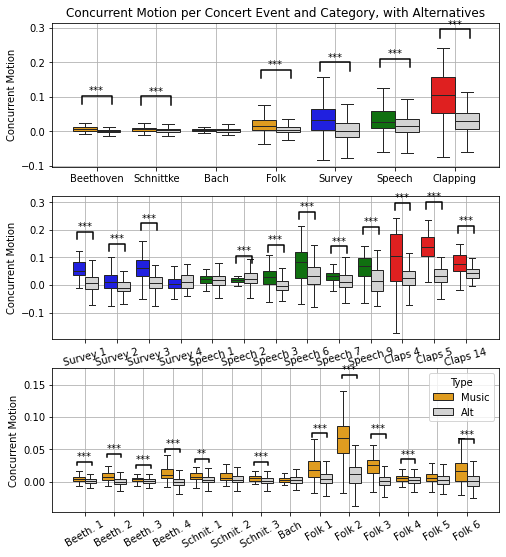

In [326]:
fig, axes= plt.subplots(3,1,figsize=(8,9))
ax = axes[0]
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']

for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs = G.query('Event_Type==@ets').copy()
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Sections1', y='Correlations', order = evord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False,ax=ax)
ax.grid()
# ax.legend(['Music','Survey','Speech','Applause','Alt'],loc='upper left')

for i in range(len(evord)):
    ev = evord[i]
    ac = pg.ttest(G.loc[G['Sections1']==ev,'Correlations'],Galt.loc[Galt['Sections1']==ev,'Correlations'])
    C = G.loc[G['Sections1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(evord),0.5)-0.25,np.ones(len(evord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(evord)),evord,rotation=0)

#
ax  = axes[1]

ETypes = ['Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
musord=G.query('Event_Type!="Music"')['Event1'].unique()
# musord = ['Survey 1', 'Survey 2','Survey 3', 'Survey 4',
#           'Speech MC1', 'Speech MC2', 'Speech MC3', 'Speech MC4', 'Speech MC5', 'Speech', 
#           'Claps 2', 'Claps 3','Claps 4', 'Claps 5', 'Claps 14']
# mustags = ['Survey 1', 'Survey 2', 'Survey 3','Survey 4', 
#            'Speech 1', 'Speech 2', 'Speech 3', 'Speech 4', 'Speech 5','Speech 6', 
#           'Applause 1','Applause 2','Applause 3','Applause 4','Applause 5']
musord = ['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4','Speech 1', 'Speech 2', 'Speech 3', 
       'Speech 6',  'Speech 7', 'Speech 9', 'Claps 4','Claps 5', 'Claps 14']
for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs = G.query('Event_Type==@ets').copy()
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False, ax=ax)

for i in range(len(musord)):
    ev = musord[i]
    ac = pg.ttest(G.loc[G['Event1']==ev,'Correlations'],Galt.loc[Galt['Event1']==ev,'Correlations'])
    C = G.loc[G['Event1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.001:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(musord)),musord,rotation=15)
ax.grid()

#
ax = axes[2]
ets = 'Music'
MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
MeanCorrs_alt['Type'] = 'Alt'
MeanCorrs = G.query('Event_Type==@ets').copy()
MeanCorrs['Type'] = ets
MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
musord=G.query('Event_Type=="Music"')['Event1'].unique()
sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue = 'Type', hue_order=['Music','Alt'], 
               showfliers = False, palette=events_palette, ax=ax)
for i in range(len(musord)):
    ev = musord[i]
    ac = pg.ttest(G.loc[G['Event1']==ev,'Correlations'],Galt.loc[Galt['Event1']==ev,'Correlations'])
    C = G.loc[G['Event1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.001:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(musord)),musord,rotation=30)
ax.grid()
axes[0].set_title('Concurrent Motion per Concert Event and Category, with Alternatives')
plt.savefig('./plots/Figure_Corrs_Alt.png', bbox_inches = 'tight',dpi = 196)

plt.show()

In [103]:
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']

for i in range(len(evord)):
    ev = evord[i]
    ac = pg.ttest(G.loc[G['Sections1']==ev,'Correlations'],Galt.loc[Galt['Sections1']==ev,'Correlations'])
    C = G.loc[G['Sections1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    print([ev,G.loc[G['Sections1']==ev,'Correlations'].mean()])
    print(ac)

['Beethoven', 0.00707903717410645]
                T        dof alternative         p-val         CI95%  \
T-test  13.082741  344.65337   two-sided  4.944587e-32  [0.01, 0.01]   

         cohen-d       BF10  power  
T-test  0.890444  1.932e+35    1.0  
['Schnittke', 0.00724382264325262]
               T         dof alternative         p-val       CI95%   cohen-d  \
T-test  5.276306  266.477507   two-sided  2.732745e-07  [0.0, 0.0]  0.339462   

             BF10     power  
T-test  6.429e+04  0.998952  
['Bach', 0.0031398679391391434]
               T         dof alternative     p-val        CI95%   cohen-d  \
T-test -0.634616  136.798077   two-sided  0.526739  [-0.0, 0.0]  0.041188   

         BF10     power  
T-test  0.157  0.064144  
['Folk', 0.023592084402538453]
                T         dof alternative         p-val         CI95%  \
T-test  12.530994  476.620902   two-sided  2.454829e-31  [0.02, 0.02]   

         cohen-d       BF10  power  
T-test  1.039133  7.946e+31    1.0  

# Social spatial influence evaluation

now consider how participants motion may have shared information through mutual influence in proximity.

Evaluate factors of proximity (adjacent, near neighbours, or in line, or far (randome sample)) and 
familiarity (strangers vs friends/family) given types of Events.

Strategy
   1. look at position vs social for pairwise (two factor anova, fully between)
   2. look at event type vs social with repeated measures (pair) (mixed)



In [831]:
df = pd.read_csv('pairwiseRelsRandDist.csv',index_col=0) 
df = df.query('index!="ADQ028" or Pair!="ADQ004"').copy() # accidental repeated pairing in the random selected set
# df = df.query('Spearman<0.9 and Spearman>-0.9').copy() # spurious identity probably from measurements turning off. Not a big enough problem (2 points) to work through how their remove unbalances the stats. 
df['absDistance'] = df['Distance'].abs()
# now add the relationships Friends
df['Social_Cat'] = 'Stranger'
df.loc[df['Relationship'].str.contains('Friend'),'Social_Cat']= 'Friend'
df.loc[df['Relationship'].str.contains('Family'),'Social_Cat']= 'Family'

df['Pairing'] = ''
for i,row in df.iterrows():
    if int(int(row['index'][3:]))>int(int(row['Pair'][3:])):
        pairname = row['Pair']+row['index']
    else: pairname = row['index']+row['Pair']
    df.loc[i,'Pairing'] = pairname
print(len(df['Pairing'].unique()))
df['Social'] = 'Familiar'
df.loc[df['Familiarity']==0,'Social'] = 'Unfamiliar'
df['Adjacent'] = 'Not adjacent'
df['Position'] = 'Far'
df.loc[df['absDistance']==3.0,'Position'] = 'Near'
df.loc[df['absDistance']==2.0,'Position'] = 'In front'
df.loc[df['absDistance']==1.0,'Position'] = 'Adjacent'
df.loc[df['absDistance']==1.0,'Adjacent'] = 'Adjacent'
df.iloc[:5,:]

909


,index,Pair,Spearman,Event_Type,Event,Event1,Sections,Relationship,Familiarity,Distance,Close,absDistance,Social_Cat,Pairing,Social,Adjacent,Position
1,ADQ002,ADQ001,-0.050404,Speech,Speech MC1,Speech 1,Speech,Stranger,0,4.0,0,4.0,Stranger,ADQ001ADQ002,Unfamiliar,Not adjacent,Far
10,ADQ011,ADQ001,-0.075044,Speech,Speech MC1,Speech 1,Speech,Stranger,0,4.0,0,4.0,Stranger,ADQ001ADQ011,Unfamiliar,Not adjacent,Far
12,ADQ013,ADQ001,-0.071902,Speech,Speech MC1,Speech 1,Speech,Stranger,0,4.0,0,4.0,Stranger,ADQ001ADQ013,Unfamiliar,Not adjacent,Far
19,ADQ020,ADQ001,-0.037554,Speech,Speech MC1,Speech 1,Speech,Stranger,0,4.0,0,4.0,Stranger,ADQ001ADQ020,Unfamiliar,Not adjacent,Far
21,ADQ022,ADQ001,0.083766,Speech,Speech MC1,Speech 1,Speech,Stranger,0,4.0,0,4.0,Stranger,ADQ001ADQ022,Unfamiliar,Not adjacent,Far


In [816]:
# number of pairings with each combination of positions
for pos in ['Adjacent','In front','Near','Far']:
    for soc in ['Familiar','Unfamiliar']:
        print(' | '.join([pos,soc,str(len(df.query('Position==@pos and Social==@soc').loc[:,'Pairing'].unique()))]))

Adjacent | Familiar | 38
Adjacent | Unfamiliar | 13
In front | Familiar | 12
In front | Unfamiliar | 162
Near | Familiar | 25
Near | Unfamiliar | 319
Far | Familiar | 0
Far | Unfamiliar | 340


Three factors of interest:

- Position: relative position of audience members to each other, with the opportunity to influence each other
- Social: whether these audience members have a reexisting relationship or are strangers
- Concert Event type: Is there a difference in simultaneous motion between neighbours, familiar or not, depending on the activity? Four categories with enough samples to check

This dataset does not allows all of these factors to tested separately. Most pairs of audience members with preexisting relationships were seated near each other, with none are in the "Far" category, and the total number of relationships testable within each distance category is uneven. Similarly for each event type, we only have a few instances, with no variation in concert event order between participants. The following analysis is thus necessarily modest in design, again highlighting patterns worth looking at more closely across other concert experiments or in more controlled conditions. 

### Single factor effects


In [817]:
measure = 'Spearman'
Factors = ['Social_Cat','Position','Event_Type']
tag_Q = 'Social_Cat'
aov = pg.anova(dv=measure,between = tag_Q,data=df)
print('\n'+tag_Q)
print(aov)
print(pg.pairwise_tests(dv=measure,between = tag_Q,data=df,padjust = 'bonf',effsize='cohen'))

tag_Q = 'Position'
aov = pg.anova(dv=measure,between = tag_Q,data=df)
print('\n'+tag_Q)
print(aov)
print(pg.pairwise_tests(dv=measure,between = tag_Q,data=df,padjust = 'bonf',effsize='cohen'))

tag_Q = 'Event_Type'
aov = pg.rm_anova(dv=measure,within = tag_Q,subject = 'Pairing',data=df)
print('\n'+tag_Q)
print(aov)
print(pg.pairwise_tests(dv=measure,within = tag_Q,data=df,subject='Pairing',padjust = 'bonf',effsize='cohen'))


Social_Cat
       Source  ddof1  ddof2          F         p-unc       np2
0  Social_Cat      2  20180  15.511291  1.856541e-07  0.001535
     Contrast       A         B  Paired  Parametric         T          dof  \
0  Social_Cat  Family    Friend   False        True  0.422260   452.909517   
1  Social_Cat  Family  Stranger   False        True  2.760272   329.118169   
2  Social_Cat  Friend  Stranger   False        True  5.030484  1587.621168   

  alternative         p-unc    p-corr p-adjust      BF10     cohen  
0   two-sided  6.730359e-01  1.000000     bonf     0.076  0.027696  
1   two-sided  6.098941e-03  0.018297     bonf     2.724  0.162901  
2   two-sided  5.448052e-07  0.000002     bonf  9441.174  0.136328  

Position
     Source  ddof1  ddof2          F         p-unc      np2
0  Position      3  20179  15.775258  3.042767e-10  0.00234
   Contrast         A         B  Paired  Parametric         T           dof  \
0  Position  Adjacent       Far   False        True  6.853362   

In [818]:
evs =  ['Music','Speech','Survey','Applause']
measure = 'Spearman'
pg.anova(data=df.query('Distance<4.0 and Event_Type in @evs'),dv=measure,between = ['Social_Cat','Position'])


,Source,SS,DF,MS,F,p-unc,np2
0,Social_Cat,0.114038,2.0,0.057019,5.169899,5.697109e-03,0.000813
1,Position,0.372519,2.0,0.186260,16.888077,4.735147e-08,0.002651
2,Social_Cat * Position,0.049209,4.0,0.012302,1.115430,3.471622e-01,0.000351
3,Residual,140.124207,12705.0,0.011029,NaN,NaN,NaN


Between the three factors, the most substantial differences in pairwise simultaneous motion are between event types, according to a repeated measures ANOVA (F(3,2622)=198.9, p<0.001) with significant differences between all categories except Speech and Surveys (Pairwise Posthoc with Bonferroni correction). This is consistent with the event type differences in simultaneous motions between individuals and the crowd in the previous section. Second most substantial factor is the relative Position of audience members (F(3,20179)=15.77, p<0.001), with posthoc pairwise testing show a significantly more simultaneous motion between Adjacently seated audience members than all other distance categories and no systematic difference between the rest. Last but still significant was audience member pairs social relationships (F(2,20180)=15.51, p<0.001), with more simultaneous motion in pairs with pre-existing relationships, but no significant difference between friends and family. Excluding the "Far" category of relative position, a two factor ANOVA between Social relationships and Position find significant effects in both factors (F(2)=5.17, p=.005, F(2)=16.89, p<.001), but no significant interaction (F(4)=1.12, p=.347) within this limited sample (Residuals d.f.= 12705, SS = 140.1).  


To simplify the comparisons to the Concert Event types, Social relationships were reduced to Familiar and UnFamiliar

However, a two-factor mixed ANOVA for Concert Event Types and Adjacency (repeated measures on the participant pairs within Concert Event Types) suggests some interaction (F(3,2619)=2.96, p=.031). Posthoc pairwise means testing with bonfirroni corrections show T
Interaction  0.050339    3  2619  0.016780    2.962326   3.101913e-02
(Welch ANOVA F (3, 89.6) = 10.86, p < .0001).
Pairwise comparison between categories caught significant
differences, with neighbours judged to be moving
”more than usual” standing out from the rest (Pairwise
Games-Howell, T (88.9) = −3.01, p = .017, T (77.6) =
−4.91, p < .0001, T (55.03) = −5.49, p < .0001).

A mixed ANOVA 

                  Source          SS       DF        MS          F  \
0             Social_Cat    0.114038      2.0  0.057019   5.169899   
1               Position    0.372519      2.0  0.186260  16.888077   
2  Social_Cat * Position    0.049209      4.0  0.012302   1.115430   
3               Residual  140.124207  12705.0  0.011029        NaN   

          p-unc       np2  
0  5.697109e-03  0.000813  
1  4.735147e-08  0.002651  
2  3.471622e-01  0.000351  
3           NaN       NaN  
     Contrast       A         B  Paired  Parametric         T          dof  \
0  Social_Cat  Family    Friend   False        True  0.422260   452.909517   
1  Social_Cat  Family  Stranger   False        True  2.591276   335.700431   
2  Social_Cat  Friend  Stranger   False        True  4.581611  1739.336678   

  alternative     p-unc    p-corr p-adjust      BF10     cohen  
0   two-sided  0.673036  1.000000     bonf     0.076  0.027696  
1   two-sided  0.009979  0.029938     bonf     1.751  0.155158  
2

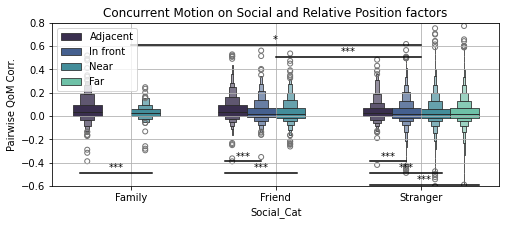

In [819]:
fig, axes = plt.subplots(1,1,figsize=(8,3)) #sharex = True

sub_corr = df.query('Distance<4.0').copy()
# social_Cat vs position
ax = axes
lp = pd.Series(['Adjacent','In front','Near','Far'])
ls = pd.Series(['Family','Friend','Stranger'])

sns.boxenplot(data = df,x='Social_Cat',y = measure,order =ls, hue = 'Position',hue_order = lp,palette = "mako",ax=ax)
ax.legend(loc='upper left')

aov = pg.anova(data=df.query('Distance<4.0'),dv=measure,between = ['Social_Cat','Position'])
print(aov)
factor = 'Social_Cat'
pair = pg.pairwise_tests(data=sub_corr,dv=measure,between=factor,padjust = 'bonf',effsize='cohen')
print(pair)#.loc[pair['p-unc']<0.05,:] 'Social',
ac = pair.loc[pair['p-corr']<0.05,:]
for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
    print(row['A'])
    am.axbarplot_annotate_brackets(ax,ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row['p-corr'],[0,1,2], [0.5,0.4,0.4], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

factor = 'Position'
pair = pg.pairwise_tests(data=df,dv=measure,between=factor,padjust = 'bonf',effsize='cohen')
print(pair)#.loc[pair['p-unc']<0.05,:] 'Social',
ac = pair.loc[pair['p-corr']<0.05,:]
positions= {0:['Near'],1:['In front','Near'],2:['In front','Near','Far']}
for k in range(3):
    for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
        print(row['B'])
        if row['B'] in positions[k]:
            am.axbarplot_annotate_brackets(ax,lp.loc[lp==row['A']].index[0], lp.loc[lp==row['B']].index[0], row['p-corr'],(np.array([0,1,2,3])/4)+k-0.35, [-0.9,-0.5,-0.6,-0.7], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

ax.set_ylim([-0.6,0.8])
ax.grid()
ax.set_ylabel('Pairwise QoM Corr.')
ax.set_title('Concurrent Motion on Social and Relative Position factors')
plt.show()


        Source        SS  DF1   DF2        MS           F          p-unc  \
0     Adjacent  0.169288    1   873  0.169288   27.050818   2.470310e-07   
1   Event_Type  3.386949    3  2619  1.128983  199.312722  1.989139e-116   
2  Interaction  0.050339    3  2619  0.016780    2.962326   3.101913e-02   

      p-GG-corr       np2       eps sphericity   W-spher        p-spher  
0           NaN  0.030055       NaN        NaN       NaN            NaN  
1  1.863304e-89  0.185872  0.763237      False  0.532773  1.633423e-116  
2           NaN  0.003382       NaN        NaN       NaN            NaN  
                 Contrast Event_Type         A             B Paired  \
0              Event_Type          -  Applause         Music   True   
1              Event_Type          -  Applause        Speech   True   
2              Event_Type          -  Applause        Survey   True   
3              Event_Type          -     Music        Speech   True   
4              Event_Type          -     Mus

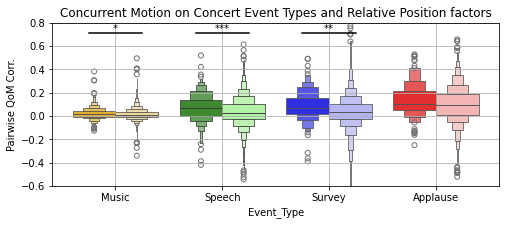

In [821]:
fig, axes = plt.subplots(1,1,figsize=(8,3)) #sharex = True
events_palette ={'Music': "blend:#FB1,#FD8", #fcba03
 'Applause':"blend:#F11,#FAA",
 'Speech': "blend:#392,#AF9",
 'Survey': "blend:#11F,#AAF"}

sub_corr = df.query('Event_Type in @evs').copy()
# Event_type vs position
ax = axes
lp = pd.Series(['Adjacent','Not adjacent'])
evs =  pd.Series(['Music','Speech','Survey','Applause'])

for ev in evs:
    sns.boxenplot(data = df.query('Event_Type == @ev'),x='Event_Type',y = measure,order =evs, 
                  hue = 'Adjacent',hue_order = lp,palette = events_palette[ev],legend=False,ax=ax)
    
aov = pg.mixed_anova(data=df.query('Event_Type in @evs'),dv='Spearman',between = 'Adjacent',within='Event_Type',subject='Pairing')
print(aov)
pair = pg.pairwise_tests(data=df.query('Event_Type in @evs'),dv='Spearman',between=['Adjacent'],within=['Event_Type'],subject='Pairing',padjust = 'bonf',effsize='cohen')
# print(pair) #.loc[pair['p-unc']<0.05,:] 'Social',
ac = pair.loc[pair['p-corr']<0.05,:]
print(ac)
factor = 'Event_Type * Adjacent'
for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
    print(row['Event_Type'])
    k = evs.loc[evs==row['Event_Type']].index[0]
    am.axbarplot_annotate_brackets(ax,0,1, row['p-corr'],(np.array([0,1])/2)+k-0.25, [0.5,0.6], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

ax.set_ylim([-0.6,0.8])
ax.grid()
ax.set_ylabel('Pairwise QoM Corr.')
ax.set_title('Concurrent Motion on Concert Event Types and Relative Position factors')
plt.show()


        Source        SS  DF1   DF2        MS           F          p-unc  \
0       Social  0.119663    1   873  0.119663   18.948981   1.501572e-05   
1   Event_Type  3.386949    3  2619  1.128983  199.336036  1.933398e-116   
2  Interaction  0.052074    3  2619  0.017358    3.064788   2.699082e-02   

      p-GG-corr       np2       eps sphericity   W-spher        p-spher  
0           NaN  0.021244       NaN        NaN       NaN            NaN  
1  1.863304e-89  0.185890  0.763237      False  0.532773  1.633423e-116  
2           NaN  0.003498       NaN        NaN       NaN            NaN  
Speech
Survey


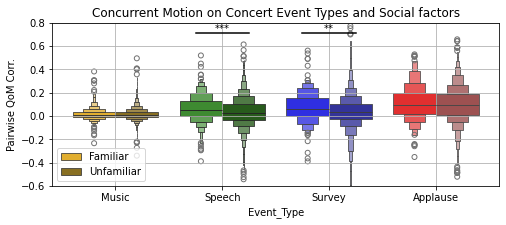

In [823]:
fig, axes = plt.subplots(1,1,figsize=(8,3)) #sharex = True
events_palette ={'Music': "blend:#FB1,#971", #fcba03
 'Applause':"blend:#F11,#A44",
 'Speech': "blend:#392,#261",
 'Survey': "blend:#11F,#22A"}

sub_corr = df.query('Event_Type in @evs').copy()
# Event_type vs Social
ax = axes
ls = pd.Series(['Familiar','Unfamiliar'])
evs =  pd.Series(['Music','Speech','Survey','Applause'])

for ev in evs:
    if ev=='Music':
        sns.boxenplot(data = sub_corr.query('Event_Type == @ev'),x='Event_Type',y = measure,order =evs, 
                      hue = 'Social',hue_order = ls,palette = events_palette[ev],ax=ax)
        ax.legend(loc='lower left')
    else:
        sns.boxenplot(data = sub_corr.query('Event_Type == @ev'),x='Event_Type',y = measure,order =evs, 
                      hue = 'Social',hue_order = ls,palette = events_palette[ev],legend=False,ax=ax)
        
aov = pg.mixed_anova(data=sub_corr,dv='Spearman',between = 'Social',within='Event_Type',subject='Pairing')
print(aov)
pair = pg.pairwise_tests(data=sub_corr,dv='Spearman',between=['Social'],within=['Event_Type'],subject='Pairing',padjust = 'bonf',effsize='cohen')
ac = pair.loc[pair['p-corr']<0.05,:]
factor = 'Event_Type * Social'
for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
    print(row['Event_Type'])
    k = evs.loc[evs==row['Event_Type']].index[0]
    am.axbarplot_annotate_brackets(ax,0,1, row['p-corr'],(np.array([0,1])/2)+k-0.25, [0.5,0.6], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

ax.set_ylim([-0.6,0.8])
ax.grid()
ax.set_ylabel('Pairwise QoM Corr.')
ax.set_title('Concurrent Motion on Concert Event Types and Social factors')
plt.show()


                  Source          SS       DF        MS          F  \
0             Social_Cat    0.114038      2.0  0.057019   5.169899   
1               Position    0.372519      2.0  0.186260  16.888077   
2  Social_Cat * Position    0.049209      4.0  0.012302   1.115430   
3               Residual  140.124207  12705.0  0.011029        NaN   

          p-unc       np2  
0  5.697109e-03  0.000813  
1  4.735147e-08  0.002651  
2  3.471622e-01  0.000351  
3           NaN       NaN  
     Contrast       A         B  Paired  Parametric         T          dof  \
0  Social_Cat  Family    Friend   False        True  0.422260   452.909517   
1  Social_Cat  Family  Stranger   False        True  2.591276   335.700431   
2  Social_Cat  Friend  Stranger   False        True  4.581611  1739.336678   

  alternative     p-unc    p-corr p-adjust      BF10     cohen  
0   two-sided  0.673036  1.000000     bonf     0.076  0.027696  
1   two-sided  0.009979  0.029938     bonf     1.751  0.155158  
2

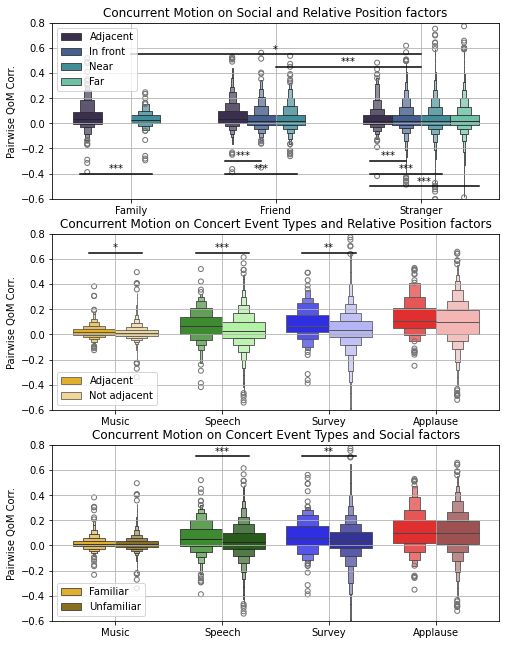

In [830]:
fig, axes = plt.subplots(3,1,figsize=(8,11)) #sharex = True
# Interaction of Distance and Concert Event
ax=axes[0]
sub_corr = df.query('Distance<4.0').copy()
# social_Cat vs position
lp = pd.Series(['Adjacent','In front','Near','Far'])
ls = pd.Series(['Family','Friend','Stranger'])

sns.boxenplot(data = df,x='Social_Cat',y = measure,order =ls, hue = 'Position',hue_order = lp,palette = "mako",ax=ax)
ax.legend(loc='upper left')

aov = pg.anova(data=df.query('Distance<4.0'),dv=measure,between = ['Social_Cat','Position'])
print(aov)
factor = 'Social_Cat'
pair = pg.pairwise_tests(data=sub_corr,dv=measure,between=factor,padjust = 'bonf',effsize='cohen')
print(pair)#.loc[pair['p-unc']<0.05,:] 'Social',
ac = pair.loc[pair['p-corr']<0.05,:]
for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
    print(row['A'])
    am.axbarplot_annotate_brackets(ax,ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row['p-corr'],[0,1,2], [0.5,0.4,0.4], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

factor = 'Position'
pair = pg.pairwise_tests(data=df,dv=measure,between=factor,padjust = 'bonf',effsize='cohen')
print(pair)#.loc[pair['p-unc']<0.05,:] 'Social',
ac = pair.loc[pair['p-corr']<0.05,:]
positions= {0:['Near'],1:['In front','Near'],2:['In front','Near','Far']}
for k in range(3):
    for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
        print(row['B'])
        if row['B'] in positions[k]:
            am.axbarplot_annotate_brackets(ax,lp.loc[lp==row['A']].index[0], lp.loc[lp==row['B']].index[0], row['p-corr'],(np.array([0,1,2,3])/4)+k-0.35, [-0.7,-0.35,-0.45,-0.55], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

ax.set_ylim([-0.6,0.8])
ax.set_xlabel('')
ax.grid()
ax.set_ylabel('Pairwise QoM Corr.')
ax.set_title('Concurrent Motion on Social and Relative Position factors')

ax=axes[1]
events_palette ={'Music': "blend:#FB1,#FD8", #fcba03
 'Applause':"blend:#F11,#FAA",
 'Speech': "blend:#392,#AF9",
 'Survey': "blend:#11F,#AAF"}

sub_corr = df.query('Event_Type in @evs').copy()
# Event_type vs position
lp = pd.Series(['Adjacent','Not adjacent'])
evs =  pd.Series(['Music','Speech','Survey','Applause'])
for ev in evs:
    if ev=='Music':
        sns.boxenplot(data = df.query('Event_Type == @ev'),x='Event_Type',y = measure,order =evs, 
                  hue = 'Adjacent',hue_order = lp,palette = events_palette[ev],ax=ax)
        ax.legend(loc='lower left')
    else:
        sns.boxenplot(data = df.query('Event_Type == @ev'),x='Event_Type',y = measure,order =evs, 
                  hue = 'Adjacent',hue_order = lp,palette = events_palette[ev],legend=False,ax=ax)
    
aov = pg.mixed_anova(data=df.query('Event_Type in @evs'),dv='Spearman',between = 'Adjacent',within='Event_Type',subject='Pairing')
print(aov)
pair = pg.pairwise_tests(data=df.query('Event_Type in @evs'),dv='Spearman',between=['Adjacent'],within=['Event_Type'],subject='Pairing',padjust = 'bonf',effsize='cohen')
ac = pair.loc[pair['p-corr']<0.05,:]
print(ac)
factor = 'Event_Type * Adjacent'
for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
    print(row['Event_Type'])
    k = evs.loc[evs==row['Event_Type']].index[0]
    am.axbarplot_annotate_brackets(ax,0,1, row['p-corr'],(np.array([0,1])/2)+k-0.25, [0.5,0.6], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

ax.set_ylim([-0.6,0.8])
ax.set_xlabel('')
ax.grid()
ax.set_ylabel('Pairwise QoM Corr.')
ax.set_title('Concurrent Motion on Concert Event Types and Relative Position factors')


events_palette ={'Music': "blend:#FB1,#971", #fcba03
 'Applause':"blend:#F11,#A44",
 'Speech': "blend:#392,#261",
 'Survey': "blend:#11F,#22A"}

sub_corr = df.query('Event_Type in @evs').copy()
# Event_type vs Social
ax = axes[2]
ls = pd.Series(['Familiar','Unfamiliar'])
evs =  pd.Series(['Music','Speech','Survey','Applause'])
for ev in evs:
    if ev=='Music':
        sns.boxenplot(data = sub_corr.query('Event_Type == @ev'),x='Event_Type',y = measure,order =evs, 
                  hue = 'Social',hue_order = ls,palette = events_palette[ev],ax=ax)
        ax.legend(loc='lower left')
    else:
        sns.boxenplot(data = sub_corr.query('Event_Type == @ev'),x='Event_Type',y = measure,order =evs, 
                  hue = 'Social',hue_order = ls,palette = events_palette[ev],legend=False,ax=ax)
        
aov = pg.mixed_anova(data=sub_corr,dv='Spearman',between = 'Social',within='Event_Type',subject='Pairing')
print(aov)
pair = pg.pairwise_tests(data=sub_corr,dv='Spearman',between=['Social'],within=['Event_Type'],subject='Pairing',padjust = 'bonf',effsize='cohen')
ac = pair.loc[pair['p-corr']<0.05,:]
factor = 'Event_Type * Social'
for i,row in ac.query('Contrast==@factor').iterrows(): # just the position info
    print(row['Event_Type'])
    k = evs.loc[evs==row['Event_Type']].index[0]
    am.axbarplot_annotate_brackets(ax,0,1, row['p-corr'],(np.array([0,1])/2)+k-0.25, [0.5,0.6], yerr=None, dh=.05, barh=.0, fs=None, maxasterix=3)

ax.set_ylim([-0.6,0.8])
ax.set_xlabel('')
ax.grid()
ax.set_ylabel('Pairwise QoM Corr.')
ax.set_title('Concurrent Motion on Concert Event Types and Social factors')
plt.savefig('./plots/Figure_PairCorrs_Factors.png', bbox_inches = 'tight',dpi = 196)

plt.show()